In [1]:
import math
import os
from tempfile import TemporaryDirectory
from typing import Tuple

import torch
from torch import nn, Tensor
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import dataset

import torch.nn.functional as F

#plotting
import matplotlib.pyplot as plt

import data_utils
import models
import importlib
import transformer_models
importlib.reload(data_utils)
importlib.reload(models)
importlib.reload(transformer_models)
from data_utils import *
from models import *
from transformer_models import * 
import torch.optim as optim
from torch.utils.data import DataLoader
import datetime
from tqdm import tqdm 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


Import the dataloader objects. Don't worry too much about this 

In [2]:
data_dir = "data/"
dataObject = xrdData("data/", device)

dataObject.make_datasets(1, composition_embedding="compositionseq")
# Create DataLoaders for train and validation sets
train_loader = DataLoader(dataObject.torch_datasets['train'], batch_size=32, shuffle=True)
valid_loader = DataLoader(dataObject.torch_datasets['val'], batch_size=32, shuffle=False)  

Create the model. The model we're most interested in is the TransformerModel since it's our model but I also have a convolutional model implementated for reference / sanity checking.

In [3]:
class L1RegularizedLoss(nn.Module):
    def __init__(self, model, criterion=nn.CrossEntropyLoss(), l=0.1, full=True):
        super().__init__()
        self.model = model
        self.criterion = criterion
        self.full = full
        self.l = l

    def __call__(self, pred, target):
        loss = self.criterion(pred, target)

        l1_reg = torch.tensor(0., requires_grad=True)
        for name, param in self.model.named_parameters():
            if 'weight' in name and (self.full or 'elem_former' in name):
                # print(param.shape)
                l1_reg = l1_reg + torch.max(torch.sum(torch.abs(param), dim=None))

        # print(loss, self.l * l1_reg)
        return loss + self.l * l1_reg
    

In [ ]:
full = False

for name, param in model.named_parameters():
        if 'weight' in name and (full or 'elem_former' in name):
            print(name, param.shape)

In [5]:
# Create the model instance and move it to the selected device
output_dim = 230  # Output dimension
ConvModel = XRD_C_SymNet(in_channels=1, output_dim=output_dim, composition_model= None).to(device)
token_size = 10 #dimension of the tokens 
TransModel = TransformerModel(ntoken = output_dim, d_model = token_size, nhead = 10, d_hid=50, nlayers=1, dropout = 0.5).to(device)
model = TransModel

# Define optimizer and loss function
weight_decay = 0  # Example value, adjust based on your needs
optimizer = optim.Adam(model.parameters(), lr=0.0002, weight_decay=weight_decay)
# criterion = nn.CrossEntropyLoss()
criterion = L1RegularizedLoss(model, nn.CrossEntropyLoss(), 1e-4)

/vast/palmer/home.mccleary/cpsc452_ijo4/.local/share/virtualenvs/cpsc452_ijo4-QeZ8YQJ2/lib64/python3.11/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


12160
torch.Size([40, 80])
torch.Size([80, 40])


In [6]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [7]:
count_parameters(ConvModel)

31369900

In [8]:
count_parameters(TransModel)

31500410

In [9]:
count_parameters(ConvModel) / count_parameters(TransModel)

0.995856879323158

This is a data augmenter that we will use to corrupt the diffraction pattern and simulate the effect of real experimental artifacts.


In [10]:
#instantiate experimental data simulator 
simulator = ExperimentalSimulation(device, crop_start=500, crop_stop = 500, noise_range = 0.1, drop_width = 100, drop_freq = 2) 

To demonstrate, I pulled a xrd from the train loader and implemented some simulated noise on it 

In [11]:
for xrd, composition, targets in train_loader:
    break

In [12]:
post_sim = simulator.sim(xrd)
post_norm = F.normalize(xrd, p=2, dim=1)

In [13]:
for_viz = xrd[1].detach().cpu().numpy()
post_sim_for_viz =  post_sim[1].detach().cpu().numpy()

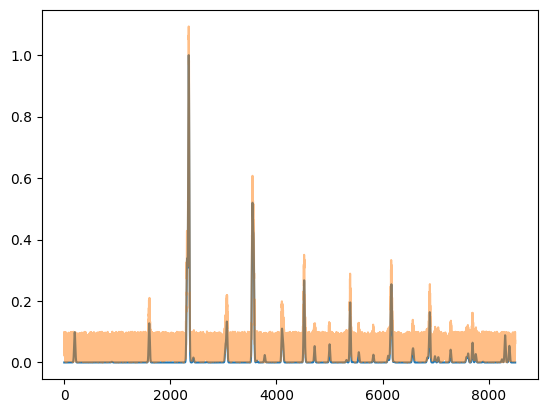

In [14]:
plt.plot(for_viz[0]) #blue = original (simulated)
plt.plot(post_sim_for_viz[0], alpha = 0.5) #orange = noise 

Finally, here's our training loop. I'll probably re-write this with pytorch lightning to make it look prettier / cleaner for submission, but I don't this it's necessary rn + in my experience lightning only run as fast and sometimes slower than a naive loop (assuming you're on a single gpu )

In [15]:
max_epochs = 200
metrics = ["accuracy", "loss"]

log = {
    f"{type}": {f"{metric}" : np.zeros(max_epochs) for metric in metrics} for type in ['train', 'val']     
}

In [16]:
for epoch in range(max_epochs):
    model.train()  # Set the model to training mode
    total_train_loss = 0
    correct_train = 0
    total_train = 0

    for xrd, composition, targets in tqdm(train_loader):
        xrd = simulator.sim(xrd)
        optimizer.zero_grad()
        outputs = model(xrd, composition)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += targets.size(0)
        correct_train += (predicted == targets).sum().item()

    train_accuracy = 100 * correct_train / total_train
    
    # Validation phase
    model.eval()  # Set the model to evaluation mode
    total_valid_loss = 0
    correct_valid = 0
    total_valid = 0

    with torch.no_grad():  # No gradients needed for validation
        for xrd, composition, targets in tqdm(valid_loader):
            xrd = simulator.sim(xrd)
            outputs = model(xrd, composition)
            loss = criterion(outputs, targets)
            total_valid_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1) 
            total_valid += targets.size(0)
            correct_valid += (predicted == targets).sum().item()

    valid_accuracy = 100 * correct_valid / total_valid

    total_train_loss = total_train_loss / len(train_loader)
    validation_loss = total_valid_loss / len(valid_loader)

    print(f"Epoch {epoch+1}, Training Loss: {total_train_loss}, Training Accuracy: {train_accuracy}%, Validation Loss: {validation_loss}, Validation Accuracy: {valid_accuracy}%")
    log['train']['accuracy'][epoch] = (train_accuracy)
    log['train']['loss'][epoch] =(total_train_loss)

    log['val']['accuracy'][epoch] =(valid_accuracy)
    log['val']['loss'][epoch] =(validation_loss)

  0%|          | 0/957 [00:00<?, ?it/s]/vast/palmer/home.mccleary/cpsc452_ijo4/.local/share/virtualenvs/cpsc452_ijo4-QeZ8YQJ2/lib64/python3.11/site-packages/torch/nn/modules/conv.py:306: UserWarning: Attempt to open cnn_infer failed: handle=0 error: libcudnn_cnn_infer.so.8: cannot open shared object file: No such file or directory (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:81.)
  return F.conv1d(input, weight, bias, self.stride,
/vast/palmer/home.mccleary/cpsc452_ijo4/.local/share/virtualenvs/cpsc452_ijo4-QeZ8YQJ2/lib64/python3.11/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,
100%|██████████| 121/121 [00:01<00:00, 110.97it/s]


Epoch 1, Training Loss: 8.344736852615979, Training Accuracy: 23.584967320261438%, Validation Loss: 5.297867514870384, Validation Accuracy: 29.596064215432417%


100%|██████████| 121/121 [00:01<00:00, 113.88it/s]


Epoch 2, Training Loss: 4.933681427498223, Training Accuracy: 30.598039215686274%, Validation Loss: 4.585770985311713, Validation Accuracy: 34.334541688244435%


100%|██████████| 121/121 [00:01<00:00, 112.36it/s]


Epoch 3, Training Loss: 4.51146308506295, Training Accuracy: 34.245098039215684%, Validation Loss: 4.3674518687665955, Validation Accuracy: 35.44795442775764%


 17%|█▋        | 20/121 [00:00<00:00, 105.60it/s]


KeyboardInterrupt: 

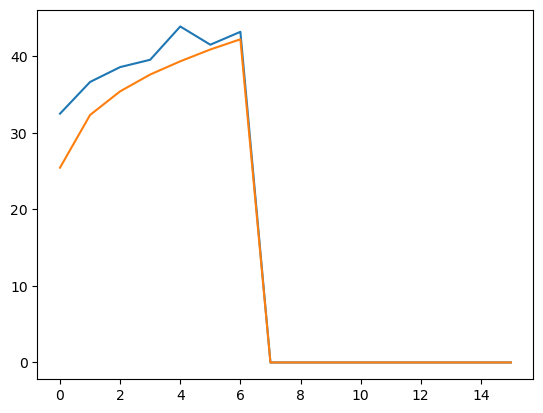

In [53]:
plt.plot(log['val']['accuracy'][:16])
plt.plot(log['train']['accuracy'][:16])

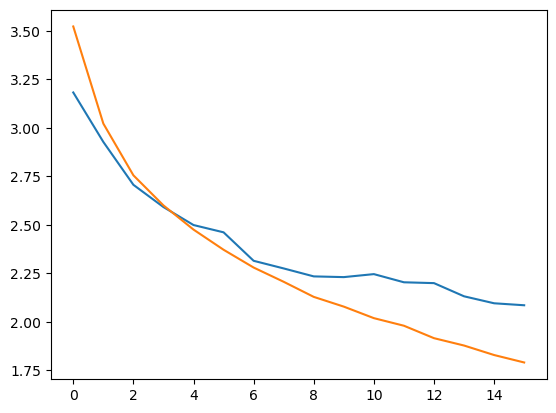

In [378]:
plt.plot(log['val']['loss'][:16])
plt.plot(log['train']['loss'][:16])

In [ ]:
model_dir = "models/"

date = datetime.now()
model_name = f"first_model_{date.month}_{date.day}"

os.makedirs(os.path.join(model_dir, model_name), exist_ok=True)

torch.save(model, os.path.join(model_dir, model_name, 'model.pth'))

for data_type, metrics_dict in log.items():
    for metric, array in metrics_dict.items():
        filename = f"{data_type}_{metric}.npy"  # Construct filename, e.g., "train_accuracy.npy"
        filename = os.path.join(model_dir, model_name, filename)
        np.save(filename, array)  # Save the array to a file

AttributeError: module 'datetime' has no attribute 'now'